目标检测数据集

李沐团队收集并标记了一个小型数据集 

下载数据集

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
# http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip

In [3]:
data_dir ='../data/banana-detection'

读取香蕉检测数据集

In [4]:
def read_data_bananas(is_train=True):
    # 读取香蕉检测数据集中的图像和标签
    data_dir ='../data/banana-detection'
    csv_fname = os.path.join(
        data_dir,
        'bananas_train' if  is_train else 'bananas_val',
        'label.csv'
    )
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(
                    data_dir,
                    'bananas_train' if  is_train else 'bananas_val',
                    'images',
                    f'{img_name}'
                )
            )
        )
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256
    

torchvision.io.read_image

`torchvision.io.read_image` 是 PyTorch 的 `torchvision` 库中的一个函数，用于读取图像文件并将其转换为 PyTorch 张量（tensor）。这个函数的目的是为了简化图像加载到 PyTorch 中的过程。

基本的使用方法是传入图像文件的路径，并可以选择性地设置一些参数来控制加载图像的方式，例如转换到特定的数据类型或进行归一化等。

这里是一个简单的示例：


```python
import torchvision.io as io

# 读取图像文件
image_tensor = io.read_image('path_to_your_image.jpg')

# 此时 image_tensor 是一个包含图像数据的 PyTorch 张量
```
在这个示例中，`io.read_image` 会读取位于 `'path_to_your_image.jpg'` 的图像文件，并返回一个包含图像数据的 PyTorch 张量。

注意：`torchvision.io.read_image` 在 PyTorch 的某些版本中可能不可用或行为可能有所不同。因此，为了获得最准确和最新的信息，建议查阅你所使用的 PyTorch 版本的官方文档。

另外，除了 `torchvision.io.read_image`，PyTorch 和 torchvision 还提供了其他工具和方法来加载、预处理和增强图像数据，例如 `torchvision.transforms` 模块。这些工具可以帮助你更灵活地处理图像数据。

---
torch.tensor(targets).unsqueeze(1) / 256

这段代码定义了一个名为 `read_data_bananas` 的函数，它的目的是从香蕉检测数据集中读取图像和对应的标签。我们逐行解释代码，并重点关注你提到的 `torch.tensor(targets).unsqueeze(1) / 256` 这部分。

首先，函数通过 `is_train` 参数确定是否读取训练集或验证集的数据。然后，它定义了一个 `data_dir` 变量，该变量指向下载和解压后的香蕉检测数据集的路径。

接着，根据 `is_train` 参数的值，它构建了指向标签 CSV 文件的路径，并使用 pandas 的 `read_csv` 函数读取这个文件。然后，它将 CSV 数据的索引设置为 'img_name' 列，这样我们就可以通过图片名称来访问对应的标签数据。

在循环中，函数遍历 CSV 数据中的每一行。对于每一行，它读取对应的图片文件，并将读取到的图片数据添加到 `images` 列表中。同时，它还将该行的标签数据转换为列表，并添加到 `targets` 列表中。

现在，我们重点关注你提到的 `torch.tensor(targets).unsqueeze(1) / 256` 这部分代码：

1. `torch.tensor(targets)`: 这部分将 `targets` 列表转换为一个 PyTorch 张量（tensor）。`targets` 列表包含从 CSV 文件中读取的标签数据。
2. `.unsqueeze(1)`: `unsqueeze` 方法用于增加张量的维度。在这里，`unsqueeze(1)` 在张量的第二个维度（索引为 1 的维度）上增加了一个维度。这样做的原因可能是模型期望的输入标签具有特定的形状或维度。例如，如果原始张量的形状是 `[N, C]`（其中 `N` 是样本数量，`C` 是类别数量），那么 `unsqueeze(1)` 后，张量的形状将变为 `[N, 1, C]`。
3. `/ 256`: 最后，整个张量被除以 256。这通常是为了归一化标签数据。在某些目标检测任务中，边界框的坐标可能是像素坐标，除以 256 可以将它们转换到 [0, 1] 的范围内，这样有助于模型的训练。

最终，这个函数返回图像列表和归一化后的标签张量。

---
创建一个自定义Dataset实例

In [5]:
class BananasDataset(torch.utils.data.Dataset):
    # 加载香蕉检测数据集的自定义数据集
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) +
              (f' training examples') if is_train else 'f validation examples')
    def __getitem__(self, idx):
        return (
            self.features[idx].float(),
            self.labels[idx]
        )
    def __len__(self):
        return len(self.features)

In [6]:
def load_data_bananas(batch_size):
    # 加载香蕉检测数据集
    train_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=True),
        batch_size,
        shuffle=True
    )
    val_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=False),
        batch_size
    )
    return train_iter, val_iter

In [7]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(
    iter(train_iter)
)
batch[0].shape, batch[1].shape

read 1000 training examples
f validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

```
batch = next(
    iter(train_iter)
)
```
在PyTorch中，`train_iter` 通常是一个迭代器（iterator），它用于从数据加载器（DataLoader）中按批次（batch）获取数据。这个迭代器通常是在创建数据加载器时自动生成的。

代码 `next(iter(train_iter))` 的含义如下：

1. `iter(train_iter)`: 这个函数会返回 `train_iter` 的迭代器对象。由于 `train_iter` 本身就是一个迭代器，所以 `iter(train_iter)` 实际上返回的就是 `train_iter` 本身。
2. `next(...)`: 这个函数用于获取迭代器中的下一个元素。在这种情况下，它会从 `train_iter` 中获取下一个批次的数据。

因此，`batch = next(iter(train_iter))` 这行代码的作用是从 `train_iter` 中获取下一个批次的数据，并将其赋值给变量 `batch`。

通常，这样的代码在训练循环的开始处出现，用于获取第一个批次的数据。然后，你可以在一个循环中使用这个 `batch` 来进行模型的训练和验证。例如：


```python
for epoch in range(num_epochs):
    batch = next(iter(train_iter))  # 获取第一个批次的数据
    for batch in train_iter:  # 遍历剩余的所有批次
        # 在这里进行模型的训练和更新
```
注意：在上面的代码中，我们首先手动获取了第一个批次的数据，然后在循环中继续遍历剩余的所有批次。这样做的一个可能原因是，我们想在训练循环的开始处执行一些特殊的操作，例如打印一些日志或执行一些验证步骤，而这些操作只需要对第一个批次的数据执行。然而，这种写法并不是必需的，因为你可以直接在循环中处理所有的批次，而不必单独处理第一个批次。

演示

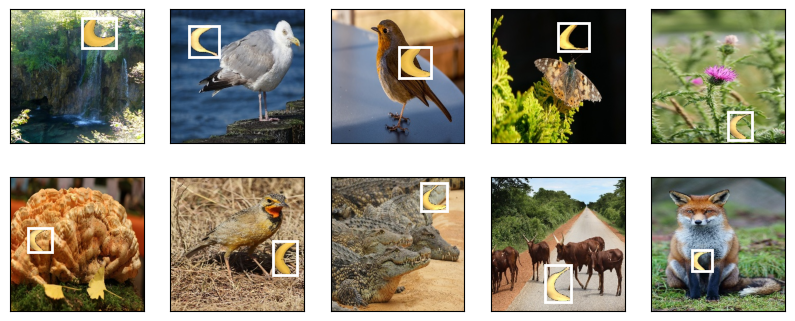

In [9]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

---
```
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
```
这行代码在PyTorch中执行了几个操作，主要针对从数据加载器（DataLoader）中获取的批次数据。让我们逐步分解这行代码：

1. **`batch[0][0:10]`**:
   - `batch` 是一个批次的数据，通常包含输入数据和对应的标签。在监督学习中，`batch` 通常是一个元组，其中第一个元素是输入数据，第二个元素是标签。
   - `batch[0]` 获取输入数据部分。
   - `batch[0][0:10]` 从输入数据中取前10个样本。假设每个样本都是一张图像，那么这会给我们一个形状为 `[10, C, H, W]` 的张量，其中 `C` 是通道数（例如，对于RGB图像，`C=3`），`H` 是图像的高度，`W` 是图像的宽度。

2. **`.permute(0, 2, 3, 1)`**:
   - `permute` 是一个张量方法，用于重新排列张量的维度。
   - `.permute(0, 2, 3, 1)` 将张量的维度从 `[10, C, H, W]` 重新排列为 `[10, H, W, C]`。这在处理图像数据时很常见，因为某些库（如PIL或matplotlib）期望图像数据的维度顺序为 `[高度, 宽度, 通道]` 而不是 `[通道, 高度, 宽度]`。

3. **`/ 255`**:
   - 这将图像数据的像素值从 `[0, 255]` 范围缩放到 `[0, 1]` 范围。这是图像处理中常见的操作，因为许多神经网络模型期望输入数据在 `[0, 1]` 或 `[-1, 1]` 范围内。

综上所述，`imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255` 这行代码从批次数据中取前10个图像样本，将它们的维度顺序调整为 `[高度, 宽度, 通道]`，并将像素值缩放到 `[0, 1]` 范围，然后将结果赋值给 `imgs` 变量。

---
```
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])
```
这段代码是用于在一个图像显示环境中，对图像上的边界框（bounding boxes）进行可视化的。这里假设你正在使用 `d2l`（深度学习教科书《动手学深度学习》的配套库）来展示图像和边界框。

下面是代码的详细解释：

1. **`axes = d2l.show_images(imgs, 2, 5, scale=2)`**:
   - 这行代码使用 `d2l.show_images` 函数来显示之前通过 `imgs` 变量准备好的10张图像。
   - `2, 5` 指定了图像的布局，即2行5列。
   - `scale=2` 可能是用来放大图像的。
   - `axes` 是一个包含matplotlib的axes对象的列表，每个axes对象对应一张显示的图像。

2. **`for ax, label in zip(axes, batch[1][0:10]):`**:
   - 这个循环遍历了 `axes` 列表和 `batch[1][0:10]`。`batch[1]` 通常是批次数据中的标签部分，对于目标检测任务，这些标签可能包含了边界框的坐标和类别信息。
   - `ax` 是当前要操作的axes对象，用于在对应的图像上绘制边界框。
   - `label` 是当前图像对应的标签信息。

3. **`d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])`**:
   - 在循环内部，这行代码调用 `d2l.show_bboxes` 函数来在当前axes对象 `ax` 上绘制边界框。
   - `label[0][1:5]` 提取了标签中的边界框坐标信息。假设 `label` 是一个形如 `[类别, x1, y1, x2, y2, ...]` 的列表或数组，`label[0][1:5]` 就会提取出 `[x1, y1, x2, y2]` 这四个坐标值。
   - `* edge_size` 表示这些坐标值可能需要乘以一个缩放因子 `edge_size`，这通常是因为原始坐标是基于图像的某种缩放或归一化版本，需要转换回原始尺寸。
   - `colors=['w']` 指定了边界框的颜色为白色。

总之，这段代码的目的是在通过 `d2l.show_images` 显示的图像上，用白色绘制出每张图像对应的边界框。这在目标检测任务中是非常常见的，有助于直观地看到模型预测的边界框与真实边界框之间的差异。